## Introduction

* The anchor-word algorithm is from [Practical Correlated Topic Modeling and Analysis via the Rectified Anchor Word Algorithm](https://moontae.people.uic.edu/papers/pdfs/Moontae_Lee-EMNLP2019.pdf). 

* I want to see how anchor-word algo works on a more realistically simulated dataset: I fit the  [sla dataset](https://zihao12.github.io/ebpmf_data_analysis/data_preprocessing_sla) with `fastTopics`. Then I use the fitted multinomial model to generate simulated data. I can change the document length to make the estimation problem easier or harder. 


## results

* Directly fitted on the simuated data gets very bad results, whereas MLE can recover $F$ very well ($\hat{L}$ is worse as it's probably a harder problem). The problem is poor $\hat{C}$

* Using true $C$, we can get almost perfect result (this also implies anchor-word assumption is satisfied)

* However, when I increase the document length by only 3 times, we can get relatively good estimate of $F$, even when $\hat{C}$ is still not good and the identified anchor-words are wrong! But the estimate of $A$ is not very good (so $L$ would be even worse)

* Therefore when either the document length is long, or there are many many documents, we can expect better estimate of $C$ and good estimate of $F$. Also how to improve estimate of $C$ can be quite an important problem for anchor-word type of methods. 


In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
from sklearn.decomposition import NMF, LatentDirichletAllocation

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread
script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions_anchor import *
from misc import *


np.random.seed(123)

In [2]:
datafile="../dataset/sla_simulated/sla_simulated_fastTopics_k6_1.mtx"
Lfile="../dataset/sla_simulated/sla_simulated_fastTopics_k6_1_trueL.csv"
Ffile="../dataset/sla_simulated/sla_simulated_fastTopics_k6_1_trueF.csv"

L = np.genfromtxt(Lfile)
F = np.genfromtxt(Ffile)
X = mmread(datafile)
k = F.shape[1]

In [3]:
Bows = X2Bows(X)
Crough, _, _ = bows2C(Bows, min_tokens=0)

[file.bows2C] Start constructing dense C...
- Counting the co-occurrence for each document...
+ Finish constructing C and D!
  - The sum of all entries = 163.084746
  - Elapsed Time = 2.2433 seconds


## Apply anchor-word algo to C w/ & w/o rectifying 

In [4]:
## 1 row/column of C is all 0, so I make them small numbers to avoid numerical issue
idx = np.where(Crough.sum(axis = 1) == 0)
Crough[idx, :] = 1e-16 
Crough[:, idx] = 1e-16

In [5]:
S1, B1, A1, Btilde1, _, _, _, _ = factorizeC(Crough, k, rectifier='no', optimizer="activeSet")

S2, B2, A2, Btilde2, _, _, _, Crec = factorizeC(Crough, k, rectifier='AP', optimizer="activeSet")

+ Start rectifying C...
  - Finish rectifying C! [0.000000]
+ Start finding the set of anchor bases S...
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 2.4383 seconds

  - Finish finding S! [2.438289]
+ Start recovering the object-cluster B...
[inference.recoverB] Start recovering the object-cluster B...
  - 0-th member...
  - 500-th member...
  - 1000-th member...
  - 1500-th member...
  - 2000-th member...
  - 2500-th member...
  - 3000-th member...
  - 3500-th member...
  - 4000-th member...
  - 4500-th member...
  - 5000-th member...
  - 5500-th member...
  - 6000-th member...
  - 6500-th member...
  - 7000-th member...
  - 7500-th member...
  - 8000-th member...
+ Finish recovering B matrix using [activeSet]
  - 6/8382 objects are converged.
  - loss = 52.2766 (By Frobenius norm).
  - Elapsed time = 17.4708 seconds.

  - Finish recovering B! [17.470778]
+ Start recove

In [6]:
tpx_idx1 = match_topics(F, B1).astype(int)
tpx_idx2 = match_topics(F, B2).astype(int)
print(tpx_idx1)
print(tpx_idx2)

[5 5 4 4 5 5]
[5 5 4 5 5 5]


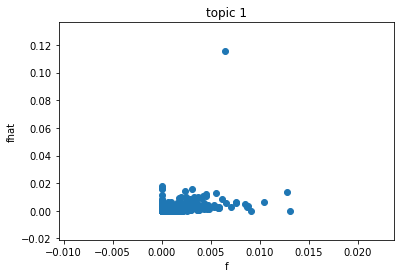

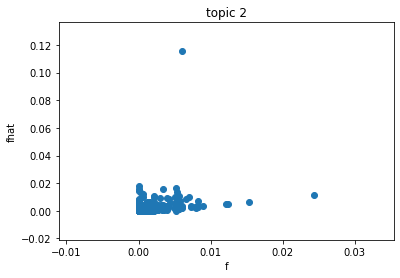

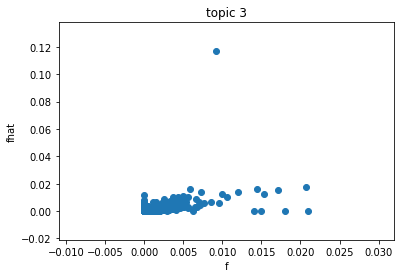

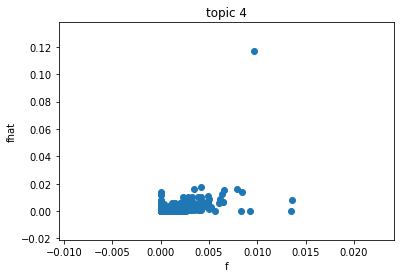

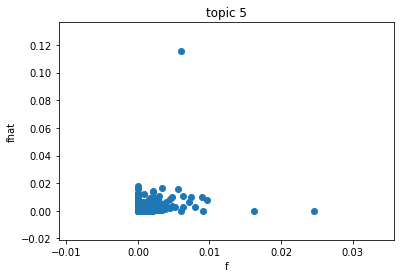

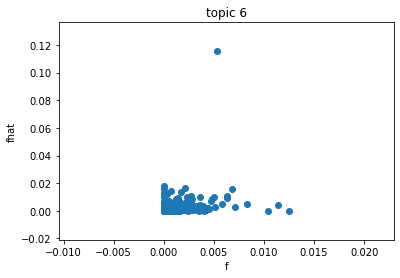

In [7]:
for i in range(k):
    plt.scatter(F[:, i], B1[:, tpx_idx1[i]])
    plt.xlabel("f")
    plt.ylabel("fhat")
    plt.title(f"topic {i + 1}")
    plt.show()

So the algorithm fails badly. Let's see why below. 

## Apply anchor-word algo given true C

In [8]:
Ctrue = F @ L.T
Ctrue = Ctrue @ Ctrue.T
Ctrue = Ctrue/Ctrue.sum()

In [9]:
S0, B0, A0, Btilde0, _, _, _, _ = factorizeC(Ctrue, k, rectifier='no', optimizer="activeSet")

+ Start rectifying C...
  - Finish rectifying C! [0.000000]
+ Start finding the set of anchor bases S...
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 2.4328 seconds

  - Finish finding S! [2.432772]
+ Start recovering the object-cluster B...
[inference.recoverB] Start recovering the object-cluster B...
  - 0-th member...
  - 500-th member...
  - 1000-th member...
  - 1500-th member...
  - 2000-th member...
  - 2500-th member...
  - 3000-th member...
  - 3500-th member...
  - 4000-th member...
  - 4500-th member...
  - 5000-th member...
  - 5500-th member...
  - 6000-th member...
  - 6500-th member...
  - 7000-th member...
  - 7500-th member...
  - 8000-th member...
+ Finish recovering B matrix using [activeSet]
  - 6/8382 objects are converged.
  - loss = 5.0904 (By Frobenius norm).
  - Elapsed time = 17.8120 seconds.

  - Finish recovering B! [17.812044]
+ Start recover

[2 1 0 4 5 3]


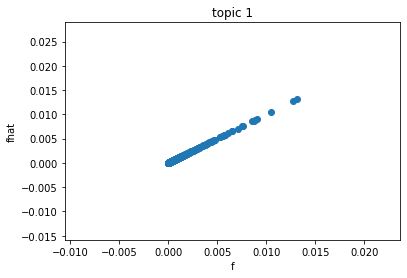

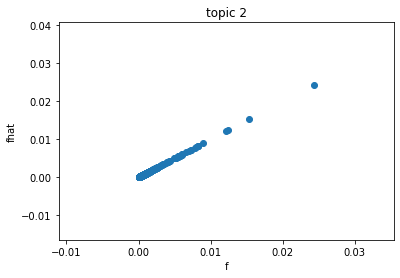

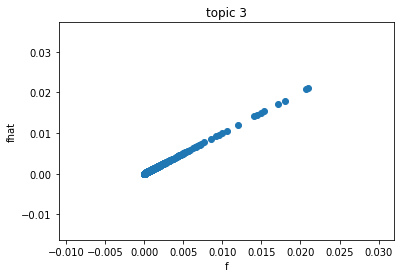

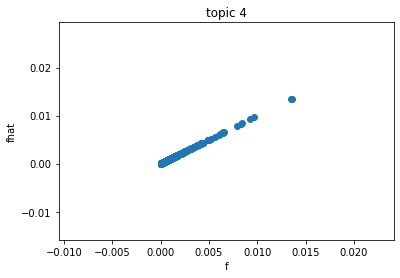

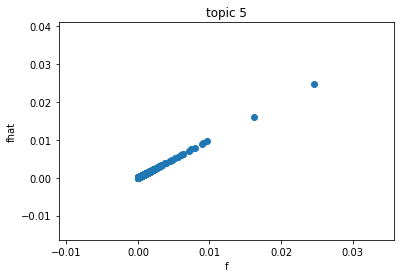

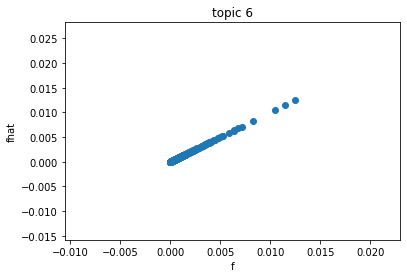

In [10]:
tpx_idx0 = match_topics(F, B0).astype(int)
print(tpx_idx0)

for i in range(k):
    plt.scatter(F[:, i], B0[:, tpx_idx0[i]])
    plt.xlabel("f")
    plt.ylabel("fhat")
    plt.title(f"topic {i + 1}")
    plt.show()

* We can see given true $C$ the estimate is perfect. 

* Below we can see in true $F$ there are real "anchor-words", and the algorithm is able to find them! The estimated  weights for those words are also very accurate!!

* On the other hand, the identified anchor words from estimated $C$ is very far from the assumptions! 

In [11]:
F[S0[tpx_idx0],].round(3)

array([[0.004, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.024, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.001, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.003, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.008, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.004]])

In [12]:
B0[np.ix_(S0[tpx_idx0],tpx_idx0)].round(3)

array([[0.004, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.024, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.001, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.003, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.008, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.004]])

In [13]:
F[S2[tpx_idx2],].round(3)

array([[0.006, 0.006, 0.006, 0.008, 0.006, 0.005],
       [0.006, 0.006, 0.006, 0.008, 0.006, 0.005],
       [0.002, 0.005, 0.009, 0.01 , 0.006, 0.003],
       [0.006, 0.006, 0.006, 0.008, 0.006, 0.005],
       [0.006, 0.006, 0.006, 0.008, 0.006, 0.005],
       [0.006, 0.006, 0.006, 0.008, 0.006, 0.005]])

Look at the estimate of A. They are basically the same!!

In [14]:
Atrue = (L.T @ L)/L.shape[0]
Atrue.round(3)

array([[0.109, 0.014, 0.024, 0.018, 0.016, 0.006],
       [0.014, 0.084, 0.018, 0.011, 0.01 , 0.008],
       [0.024, 0.018, 0.136, 0.022, 0.016, 0.017],
       [0.018, 0.011, 0.022, 0.115, 0.013, 0.005],
       [0.016, 0.01 , 0.016, 0.013, 0.08 , 0.008],
       [0.006, 0.008, 0.017, 0.005, 0.008, 0.065]])

In [15]:
A0[np.ix_(tpx_idx0, tpx_idx0)].round(3)

array([[0.109, 0.014, 0.024, 0.018, 0.016, 0.006],
       [0.014, 0.084, 0.018, 0.011, 0.01 , 0.008],
       [0.024, 0.018, 0.136, 0.022, 0.016, 0.017],
       [0.018, 0.011, 0.022, 0.115, 0.013, 0.005],
       [0.016, 0.01 , 0.016, 0.013, 0.08 , 0.008],
       [0.006, 0.008, 0.017, 0.005, 0.008, 0.065]])

## Can we recover $F, A$ with the right anchor-words, but with poor $\hat{C}$?

In [16]:
C_ = Crec
C_rowSums = C_.sum(axis = 1)
Cbar = C_/C_rowSums[:,None]
Bhat, _, _ = recoverB(Cbar, C_rowSums, S0, "activeSet")

match_topics(F, Bhat).astype(int)

[inference.recoverB] Start recovering the object-cluster B...
  - 0-th member...
  - 500-th member...
  - 1000-th member...
  - 1500-th member...
  - 2000-th member...
  - 2500-th member...
  - 3000-th member...
  - 3500-th member...
  - 4000-th member...
  - 4500-th member...
  - 5000-th member...
  - 5500-th member...
  - 6000-th member...
  - 6500-th member...
  - 7000-th member...
  - 7500-th member...
  - 8000-th member...
+ Finish recovering B matrix using [activeSet]
  - 6/8382 objects are converged.
  - loss = 2.3692 (By Frobenius norm).
  - Elapsed time = 8.1149 seconds.



array([2, 2, 2, 2, 2, 2])

The $\hat{F}$ is still very bad. 

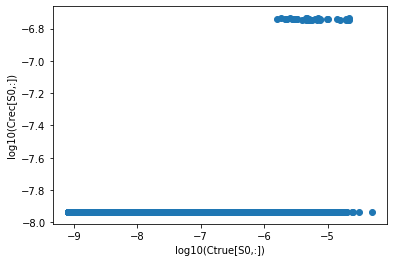

In [17]:
plt.scatter(np.log10(Ctrue[S0,:]).flatten(), 
           np.log10(Crec[S0,:]).flatten())
plt.xlabel("log10(Ctrue[S0,:])")
plt.ylabel("log10(Crec[S0,:])")
plt.show()

/Users/ontheroad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


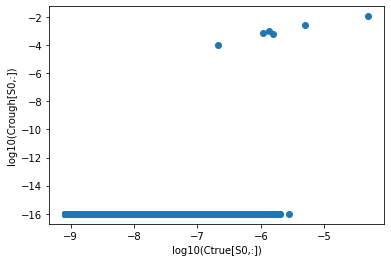

In [18]:
plt.scatter(np.log10(Ctrue[S0,:]).flatten(), 
           np.log10(Crough[S0,:]).flatten())
plt.xlabel("log10(Ctrue[S0,:])")
plt.ylabel("log10(Crough[S0,:])")
plt.show()

In [19]:
print("## frequency of those anchor words")
print(X.toarray()[:,S0].sum(axis = 0))
print("## frequency of all words in quantile")
print(np.quantile(a = X.toarray().sum(axis = 0), q = np.array([0.5, 0.75, 0.9, 0.95, 0.99])))

## frequency of those anchor words
[ 66 883 178 136 188 330]
## frequency of all words in quantile
[  6.  19.  66. 131. 483.]


* Even though the true anchor words appear rather frequently, the rest of the vocabulary have so many iunfrequent words.

* Since $C_{ij} = Pr(X_1 = i, X_2 = j)$, we expect most entries to be estimated very poorly, because at least one of $X_1, X_2$ are very very rare. 

* No wonder the authors' original codes emphasize pre-processing vocabulary. 

## Apply anchor-word algo on dataset with stronger signal

I increase the document length 3-fold and see how the algorithm performs (use the same $L, F$)

In [20]:
np.random.seed(123)
Xnew,w_idct, F = simulate_multinomial_counts(L, F, 3*X.sum(axis = 1))
Xnew = sparse.coo_matrix(Xnew)

Cnew, _, _ = X2C(Xnew)
Snew, Bnew, Anew, _, _, _, _, Cnew = factorizeC(Cnew, K=k, rectifier='AP', optimizer='activeSet')

[file.bows2C] Start constructing dense C...
- Counting the co-occurrence for each document...
+ Finish constructing C and D!
  - The sum of all entries = 1.000000
  - Elapsed Time = 11.3872 seconds
+ Start rectifying C...
+ Start alternating projection
  - 1-th iteration... (9.444808e-05 / 4.460321e-09)
  - 2-th iteration... (1.575090e-07 / 4.460359e-09)
  - 3-th iteration... (1.059013e-07 / 4.460400e-09)
  - 4-th iteration... (7.866566e-08 / 4.460438e-09)
  - 5-th iteration... (6.207659e-08 / 4.460470e-09)
  - 6-th iteration... (5.089450e-08 / 4.460499e-09)
  - 7-th iteration... (4.293063e-08 / 4.460524e-09)
  - 8-th iteration... (3.702061e-08 / 4.460546e-09)
  - 9-th iteration... (3.246797e-08 / 4.460567e-09)
  - 10-th iteration... (2.889322e-08 / 4.460585e-09)
  - 11-th iteration... (2.602137e-08 / 4.460602e-09)
  - 12-th iteration... (2.365883e-08 / 4.460618e-09)
  - 13-th iteration... (2.168444e-08 / 4.460632e-09)
  - 14-th iteration... (2.002681e-08 / 4.460646e-09)
  - 15-th iter

In [21]:
Ctrue_new = F @ L.T
Ctrue_new = Ctrue_new @ Ctrue_new.T
Ctrue_new = Ctrue_new/Ctrue_new.sum()

Snew0, Bnew0, Anew0, _, _, _, _, _ = factorizeC(Ctrue_new, K=k, rectifier='no', optimizer='activeSet')


+ Start rectifying C...
  - Finish rectifying C! [0.000000]
+ Start finding the set of anchor bases S...
[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 2.3704 seconds

  - Finish finding S! [2.370379]
+ Start recovering the object-cluster B...
[inference.recoverB] Start recovering the object-cluster B...
  - 0-th member...
  - 500-th member...
  - 1000-th member...
  - 1500-th member...
  - 2000-th member...
  - 2500-th member...
  - 3000-th member...
  - 3500-th member...
  - 4000-th member...
  - 4500-th member...
  - 5000-th member...
  - 5500-th member...
  - 6000-th member...
  - 6500-th member...
  - 7000-th member...
  - 7500-th member...
  - 8000-th member...
+ Finish recovering B matrix using [activeSet]
  - 6/8378 objects are converged.
  - loss = 5.0891 (By Frobenius norm).
  - Elapsed time = 17.4810 seconds.

  - Finish recovering B! [17.480969]
+ Start recover

In [22]:
tpx_idxnew = match_topics(F, Bnew).astype(int)
tpx_idxnew0 = match_topics(F, Bnew0).astype(int)

print(tpx_idxnew)
print(tpx_idxnew0)

[2 1 0 4 3 5]
[2 1 0 4 5 3]


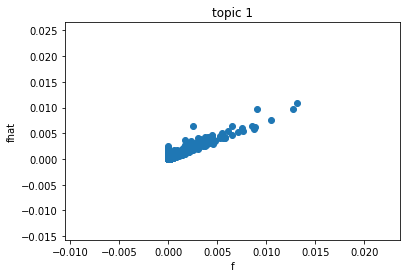

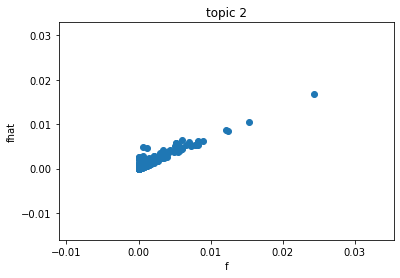

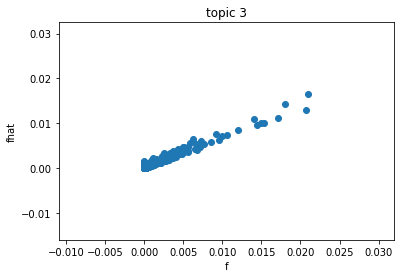

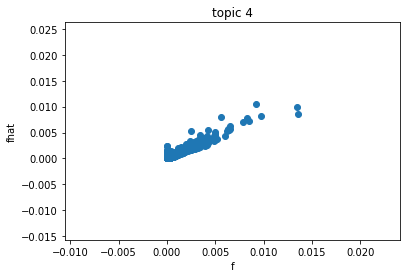

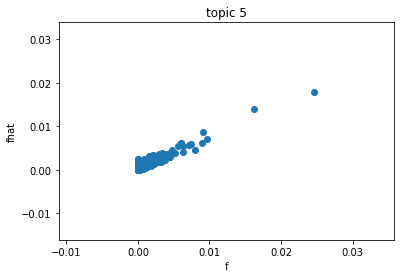

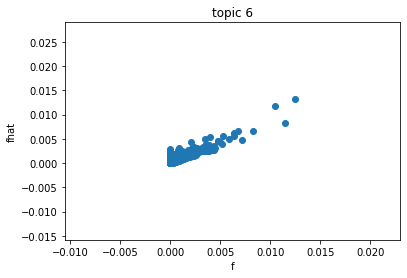

In [23]:
for i in range(k):
    plt.scatter(F[:, i], Bnew[:, tpx_idxnew[i]])
    plt.xlabel("f")
    plt.ylabel("fhat")
    plt.title(f"topic {i + 1}")
    plt.show()

In [24]:
print(Snew[tpx_idxnew])
print(Snew0[tpx_idx0])

[6914 4485 1201 4968 1272 2309]
[5821 7567 4660 4085 7109 1021]


In [25]:
F[Snew[tpx_idxnew],].round(5)

array([[4.e-05, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 5.e-05, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 8.e-05, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 4.e-05, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 2.e-05, 3.e-05],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 5.e-05]])

In [26]:
Bnew[np.ix_(Snew[tpx_idxnew], tpx_idxnew)].round(5)

array([[4.e-05, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 2.e-05, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 5.e-05, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 1.e-05, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-05, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 3.e-05]])

The identified anchor words do not all satisfy the assumption. Still, the diagonal elements are okay. 

In [27]:
Anew0.round(3)

array([[0.136, 0.018, 0.024, 0.017, 0.022, 0.016],
       [0.018, 0.084, 0.014, 0.008, 0.011, 0.01 ],
       [0.024, 0.014, 0.109, 0.006, 0.018, 0.016],
       [0.017, 0.008, 0.006, 0.065, 0.005, 0.008],
       [0.022, 0.011, 0.018, 0.005, 0.115, 0.013],
       [0.016, 0.01 , 0.016, 0.008, 0.013, 0.08 ]])

In [28]:
Anew[np.ix_(tpx_idxnew, tpx_idxnew)].round(3)

array([[0.245, 0.   , 0.   , 0.   , 0.   , 0.006],
       [0.   , 0.172, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.406, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.262, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.211, 0.   ],
       [0.006, 0.   , 0.   , 0.   , 0.   , 0.128]])

The estimated $\hat{A}$ is also not good. If we use $\hat{F}$ to estimate $L$, I expect the estimate to be poor.  

Look at $\hat{C}$ (after rectifying)

/Users/ontheroad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


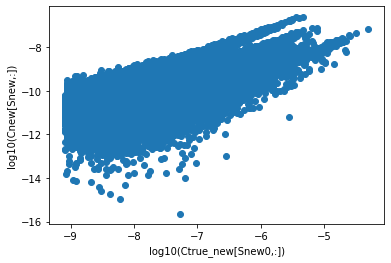

In [29]:
plt.scatter(np.log10(Ctrue_new[Snew0[tpx_idxnew0],:]).flatten(),
           np.log10(Cnew[Snew[tpx_idxnew],:]).flatten())
plt.xlabel("log10(Ctrue_new[Snew0,:])")
plt.ylabel("log10(Cnew[Snew,:])")
plt.show()

/Users/ontheroad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


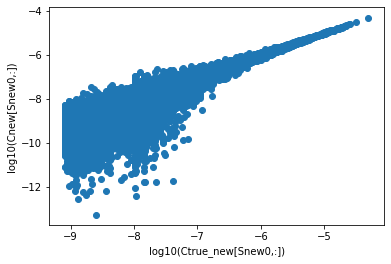

In [30]:
plt.scatter(np.log10(Ctrue_new[Snew0,:]).flatten(),
           np.log10(Cnew[Snew0,:]).flatten())
plt.xlabel("log10(Ctrue_new[Snew0,:])")
plt.ylabel("log10(Cnew[Snew0,:])")
plt.show()

$\hat{C}$ is still bad for smaller elements. However, when it's good for larger elements, it seems enough to get a good estimate of $F$. 